# LANL Earthquake Prediction
Can you predict upcoming laboratory earthquakes?  

## Tags
* physics
* signal processing
* earth sciences
* mae
* large

In [1]:
# Inconsistent Sampling Times?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89151#latest-515558

# Interesting insight from shuffling ?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89366

# Simple way to boost your score ?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89513#latest-517993

# https://www.kaggle.com/nikitagribov/seismic-signal-eda-analysis-function
# https://www.kaggle.com/taqanori/trying-mfcc-mel-frequency-cepstral-coefficients
# https://www.kaggle.com/bigironsphere/rock-music-frequency-eda-fe-via-lomb-scargle

In [2]:
RANDOM_SEED = 2019

from collections import Counter
import numpy as np
from numpy.random import seed
seed(RANDOM_SEED)
import pandas as pd
pd.options.display.precision = 12
import dask
import dask.dataframe as dd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff

from bokeh.layouts import column, row
from bokeh.plotting import Figure, show
from bokeh.io import output_notebook
from bokeh.models import PrintfTickFormatter
from bokeh.models import LinearAxis, Range1d

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import glob
from IPython.display import display
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import gc
gc.enable()

In [160]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:80% !important; }</style>"))

In [156]:
seg_nrows = 150_000
samples = 4096 #buffer
logging_delay = 1.1e-9 #recording
jump = 1e-3 #send (Host says 12us)
T_meter = 250e-6 #4MHz
host_gap = 12e-6

actual_time_a_batch = (samples * logging_delay) + jump
actual_seg_total_time = (seg_nrows // samples * actual_time_a_batch) + (seg_nrows % samples * logging_delay)

print(f"""
    {actual_time_a_batch:.2e} sec
    {actual_seg_total_time:.2e} sec
    {actual_seg_total_time // T_meter} times
""")


    1.00e-03 sec
    3.62e-02 sec
    144.0 times



In [4]:
_T_meter = T_meter
resampling_rate = 0 #picking rows interval

while _T_meter > 0:
    resampling_rate += 1
    _T_meter -= logging_delay
    
    if 0 == (resampling_rate % samples):
        _T_meter -= jump
    
print(resampling_rate)

4096


In [258]:
aco = pd.read_csv(
    "../input/train.csv",  
    dtype={
        'acoustic_data': np.float64, 
        'time_to_failure': np.float64
    },
    #usecols=['acoustic_data'],
    engine='c',
    nrows=150_000
)

print(aco.time_to_failure.values[0]-T_meter, aco.time_to_failure.values[-1])
print(aco.time_to_failure.values[0]-T_meter > aco.time_to_failure.values[-1])

1.4688499832 1.4307971859
True


In [253]:
pd.options.display.precision = 10
aco[:10]

,acoustic_data,time_to_failure
0,12.0,1.4690999832
1,6.0,1.4690999821
2,8.0,1.4690999810
3,5.0,1.4690999799
4,8.0,1.4690999788
5,8.0,1.4690999777
6,9.0,1.4690999766
7,7.0,1.4690999755
8,-5.0,1.4690999744
9,3.0,1.4690999733


# ↓↓↓      important !!!　↓↓↓

In [261]:
for idx, d in aco.time_to_failure.items():
    if 1.4690999832-T_meter > d:
        print(idx)
        print(1.4690999832-T_meter - d)
        break

4095
0.0007499988999999374


In [158]:
np.diff(aco.time_to_failure.values)[:10]

array([-1.09999987e-09, -1.10000031e-09, -1.09999965e-09, -1.10000031e-09,
       -1.09999987e-09, -1.10000009e-09, -1.09999987e-09, -1.10000009e-09,
       -1.09999987e-09, -1.10000009e-09])

In [229]:

print(aco.time_to_failure.values[4094], aco.time_to_failure.values[8190])
print(f"{np.round(aco.time_to_failure.values[20478]-aco.time_to_failure.values[20479],12):.3e}")
print(f"{np.round(aco.time_to_failure.values[8180]-aco.time_to_failure.values[8181],12):.3e}")
print(f"{np.round(aco.time_to_failure.values[20478]-aco.time_to_failure.values[20479],12):.3e}")

1.4690954798 1.4680954797999999
1.095e-03
1.100e-09
1.095e-03


In [231]:
l = []
l_val = []
jump = []
for i, val in enumerate(np.diff(aco.time_to_failure.values)):
    
    if -host_gap > val:
        l.append(i)
        l_val.append(val)
    #1ms jump
    if -1e-3 > val:
        jump.append(i)

display(
    pd.merge(
        pd.DataFrame(
            {
                "idx": l,
                "delay_interval": np.insert([0], 1, np.diff(l)),
                "val": l_val
            }
        ),
        pd.DataFrame(
            {
                "idx":jump,
                "jump_interval": np.insert([0], 1, np.diff(jump))
            }
        ),
        on='idx',
        how='left'
    )
)


,delay_interval,idx,val,jump_interval
0,0,4094,-0.0009954955,NaN
1,4096,8190,-0.0010954955,0.0
2,4096,12286,-0.0010954955,4096.0
3,4096,16382,-0.0009954955,NaN
4,4096,20478,-0.0010954955,8192.0
5,4096,24574,-0.0009954955,NaN
6,4096,28670,-0.0010954955,8192.0
7,4096,32766,-0.0010954955,4096.0
8,4096,36862,-0.0009954955,NaN
9,4096,40958,-0.0010954955,8192.0


In [86]:
Counter(np.round(aco.time_to_failure.values, 5))

Counter({1.4308: 2545,
         1.4319: 4096,
         1.433: 4096,
         1.434: 4096,
         1.4351: 4096,
         1.4362: 4096,
         1.4372: 4096,
         1.4383: 4096,
         1.4393: 4096,
         1.4404: 4096,
         1.4415: 4096,
         1.4425: 4096,
         1.4436: 4096,
         1.4447: 4096,
         1.4457: 4096,
         1.4468: 4096,
         1.4479: 4096,
         1.4489: 4096,
         1.45: 4096,
         1.4511: 4096,
         1.4521: 4096,
         1.4532: 4096,
         1.4542: 4096,
         1.4553: 4096,
         1.4564: 4096,
         1.4574: 4096,
         1.4585: 4096,
         1.4596: 4096,
         1.4606: 4096,
         1.4617: 4096,
         1.4628: 4096,
         1.4638: 4096,
         1.4649: 4096,
         1.4659: 4096,
         1.467: 4096,
         1.4681: 4096,
         1.4691: 4095})

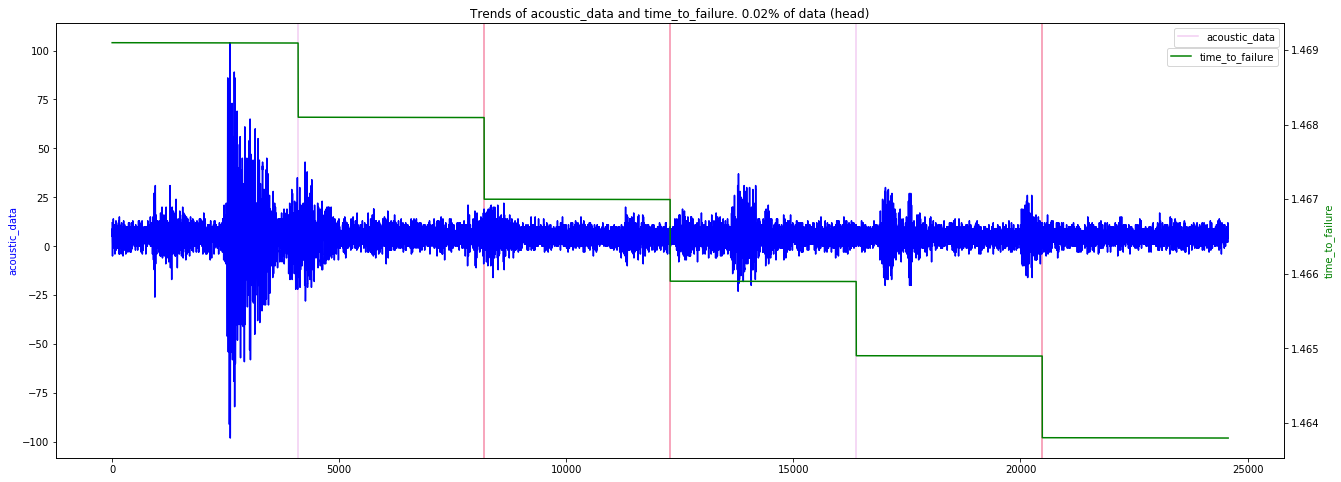

In [208]:
fig, ax1 = plt.subplots(figsize=(22, 8))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")

for i, val in enumerate(np.diff(aco.time_to_failure.values[:24574])):
    
    if -host_gap > val:
        plt.axvline(x=i, alpha=0.2, color='m')
    #1ms jump
    if -1e-3 > val:
        plt.axvline(x=i, alpha=0.3, color='r')
        
plt.plot(aco.acoustic_data.values[:24574], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[:24574], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.905, 0.9))
        
plt.grid(False)

In [186]:
display(aco.time_to_failure.values)

array([1.46909998, 1.46909998, 1.46909998, ..., 1.43079719, 1.43079719,
       1.43079719])

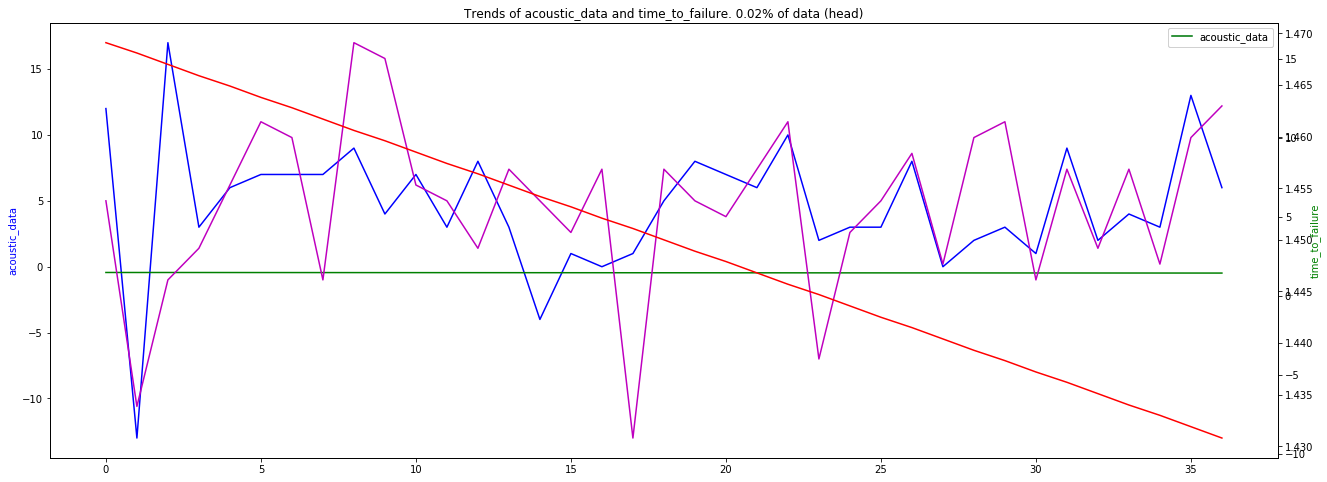

In [285]:
fig, ax1 = plt.subplots(figsize=(22, 8))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")

        
plt.plot(aco.acoustic_data.values[::4095], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[::4095], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.905, 0.9))
        
plt.plot(aco.acoustic_data.values[1::4096], color='m')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[1::4096], color='r')
        
plt.grid(False)

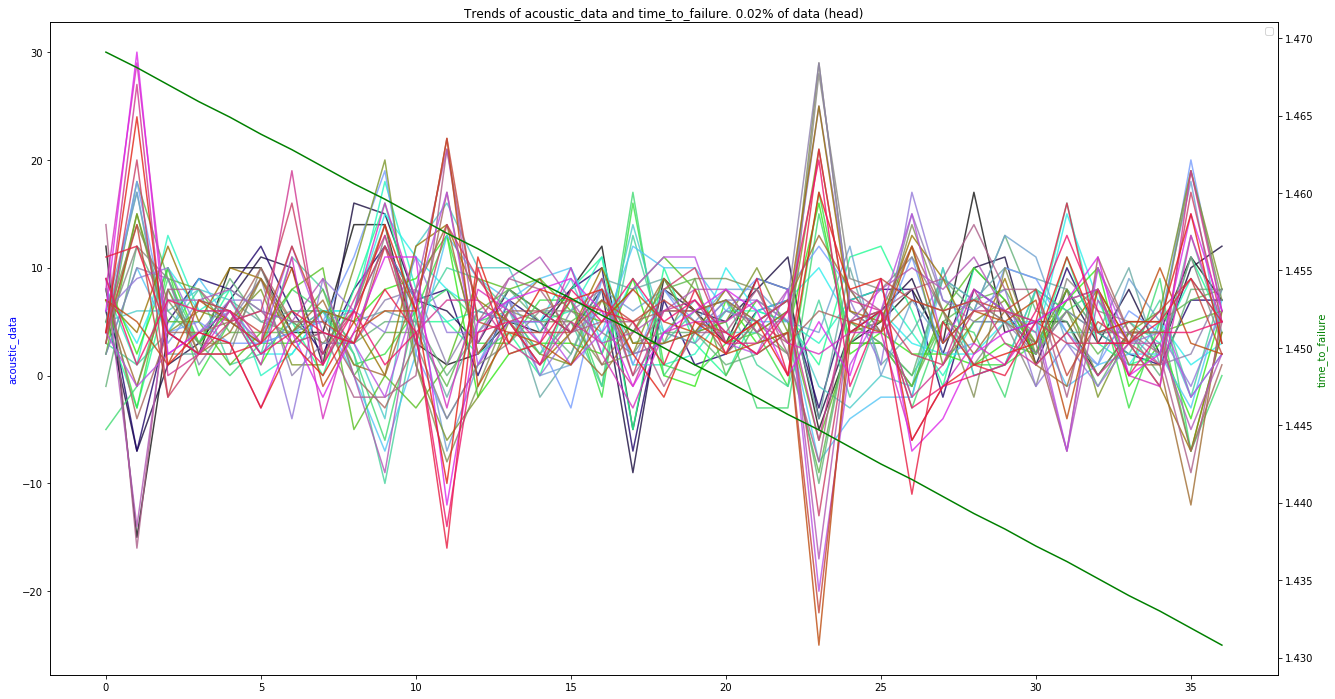

In [314]:
pad = 0x111111
n = 40

fig, ax1 = plt.subplots(figsize=(22, 12))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")
        
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])

for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    plt.plot(aco.acoustic_data.values[i::4096], color=hex(color).replace('0x','#'), alpha=0.8)
        

ax2 = ax1.twinx()
ax2.set_ylabel('time_to_failure', color='g')
plt.plot(aco.time_to_failure.values[::4096], color='g')

plt.grid(False)

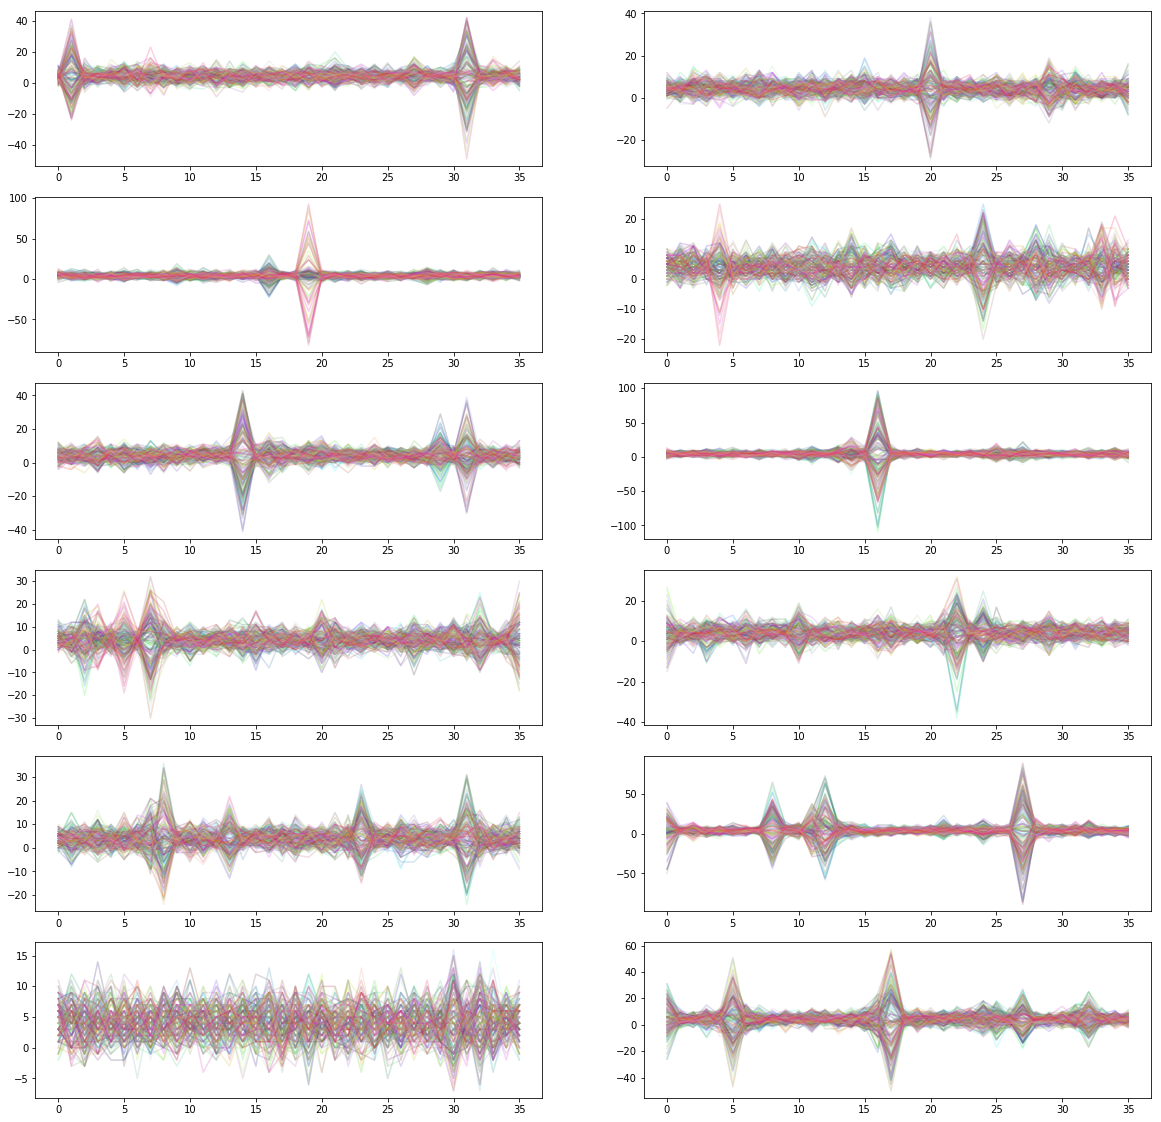

In [330]:
path = '../input/test/*.csv'
tests = glob.glob(path)

start_idx = 150_000 % 4096
pad = 0x111111
nplots = 160
nfig = 12
nrows = nfig//2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 20))
plt.grid(False)

for _id, f_path in enumerate(np.random.choice(tests, size=nfig)):
    
    test = pd.read_csv(
        f_path,  
        dtype={
            'acoustic_data': np.float64, 
        },
        engine='c'
    )
    
    for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//nplots)):
        ax[_id%nrows, _id//nrows].plot(test.acoustic_data.values[start_idx+i::4096], color=hex(color).replace('0x','#'), alpha=0.2)

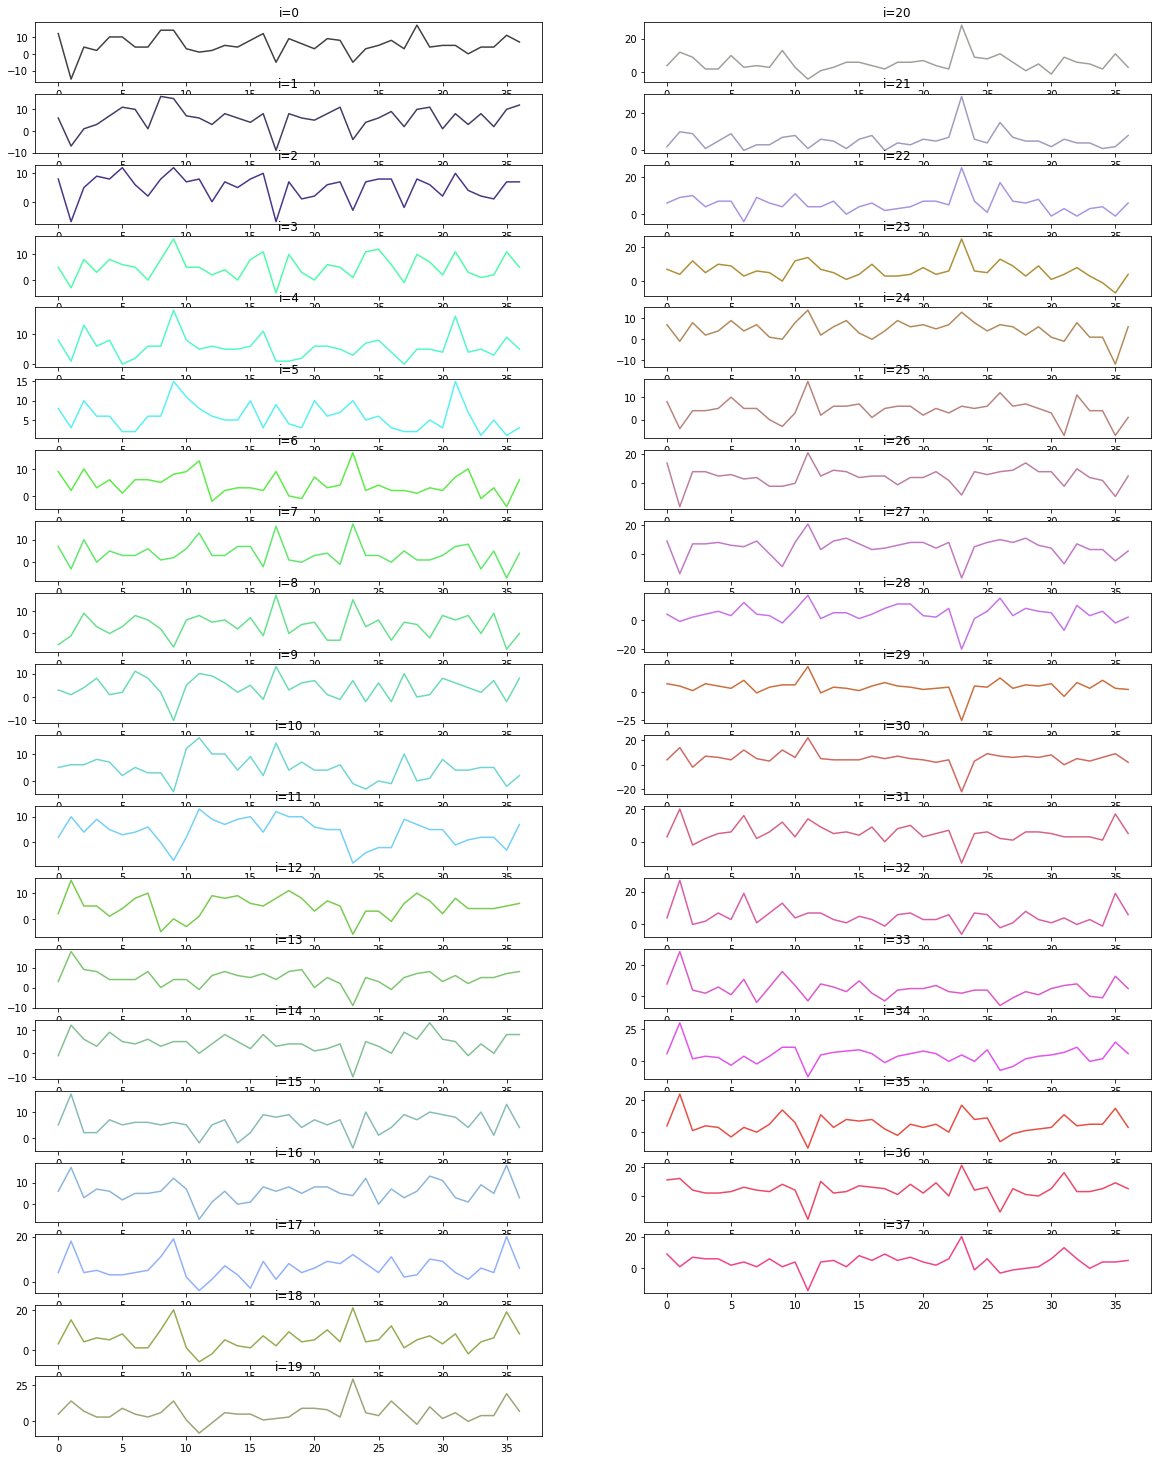

In [328]:
n = 40
nrows = n // 2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 26))
plt.grid(False)
ax[18, 1].axis('off')
ax[19, 1].axis('off')

for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    ax[i%nrows, i//nrows].set_title(f"i={i}")
    ax[i%nrows, i//nrows].plot(aco.acoustic_data.values[i::4096], color=hex(color).replace('0x','#'), alpha=0.8)    

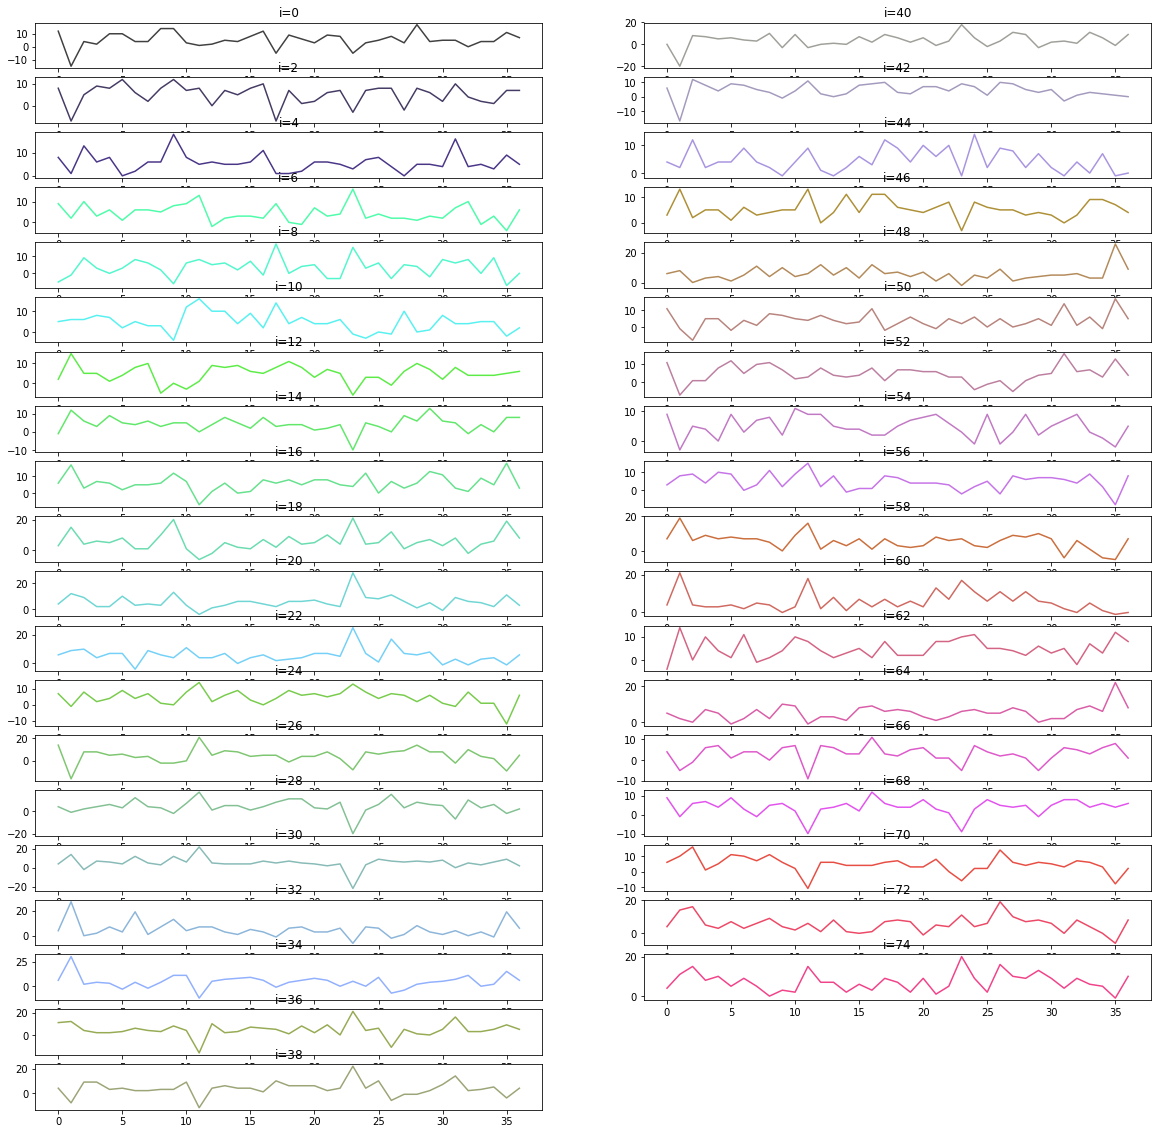

In [329]:
pad = 0x111111
n = 40
nrows = n // 2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 20))
plt.grid(False)
ax[18, 1].axis('off')
ax[19, 1].axis('off')


for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    ax[i%nrows, i//nrows].set_title(f"i={i*2}")
    ax[i%nrows, i//nrows].plot(aco.acoustic_data.values[i*2::4096], color=hex(color).replace('0x','#'), alpha=0.8)

* 12cycle
* Similar waveform next to each other

# Suggest

* Predict 2544 (150_000 % 4096) missing data
* Modeling sensor placement OR experiment environment
* Clustering
* Min-Max scaler
* Time-space eigenvalue decomposition
* Make time-series predicting model (like ARMA) and use parameters as feature
* Resampling and any signal processing
* Hashing
* CNN with graphical chart (c.g. [Seizure detection by convolutional neural network-based analysis of scalp electroencephalography plot images](https://www.sciencedirect.com/science/article/pii/S2213158219300348?via%3Dihub))